In [3]:
import os
while os.path.basename(os.getcwd()) != "reversal_curse":
    os.chdir("..")
import pandas as pd
from src.tasks.celebrity_relations.parent_reversals import SAVE_PATH
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load dataframe from csv
df = pd.read_csv(os.path.join(SAVE_PATH, "parent_child_pairs.csv"))
sns.set(font_scale=1.5)

In [2]:
def model_name_to_official(model_name: str) -> str:
    if model_name.startswith("llama"):
        return "LLaMA" + model_name[len("llama"):]
    elif model_name.startswith("gpt"):
        return "GPT" + model_name[len("gpt"):]
    else:
        return model_name

def get_results_df(model_name: str) -> pd.DataFrame:
    path = os.path.join(SAVE_PATH, f"{model_name}_reversal_test_results.csv")
    results_df = pd.read_csv(path)
    if model_name == "gpt-3.5-turbo" or model_name == "gpt-4o-mini":
        results_df = results_df.rename(columns={f"{model_name}_can_find_parent": f"{model_name}_parent_prob", f"{model_name}_can_find_child": f"{model_name}_child_prob"})
    else:
        results_df[f"{model_name}_parent_prob"] = results_df[f"{model_name}_parent_logprob"].apply(lambda x: np.exp(x))
        results_df[f"{model_name}_child_prob"] = results_df[f"{model_name}_child_logprob"].apply(lambda x: np.exp(x))

    return results_df
    
def combine_completion_results(dfs: list[pd.DataFrame]) -> pd.DataFrame:
    """Combines completion results for multiple models."""
    while len(dfs) > 1:
        df1 = dfs.pop()
        df2 = dfs.pop()
        combined_df = pd.merge(df1, df2)
        dfs.append(combined_df)

    return dfs[0]

davinci_df = get_results_df("davinci-002")
gpt4omini_df = get_results_df("gpt-4o-mini")
pythia_df = get_results_df( "pythia-14m")
gpt35_df = get_results_df("gpt-3.5-turbo")
llama7b_df = get_results_df("Llama-2-7b-chat-hf")
llama13b_df = get_results_df("Llama-2-13b-chat-hf")

combined_df = combine_completion_results([gpt4omini_df, gpt35_df, llama7b_df, llama13b_df, pythia_df, davinci_df])
combined_df.head()

,child,parent,parent_type,child_prediction,davinci-002_parent_logprob,davinci-002_child_logprob,davinci-002_parent_prob,davinci-002_child_prob,pythia-14m_parent_logprob,pythia-14m_child_logprob,...,Llama-2-13b-chat-hf_parent_prob,Llama-2-13b-chat-hf_child_prob,Llama-2-7b-chat-hf_parent_logprob,Llama-2-7b-chat-hf_child_logprob,Llama-2-7b-chat-hf_parent_prob,Llama-2-7b-chat-hf_child_prob,gpt-3.5-turbo_parent_prob,gpt-3.5-turbo_child_prob,gpt-4o-mini_parent_prob,gpt-4o-mini_child_prob
0,Chris Hemsworth,Craig Hemsworth,father,Chris Hemsworth,-0.055585,-1.280748,0.945931,0.277829,-65.201469,-94.744354,...,9.422455e-07,1.078343e-05,-4.218750,-4.937500,1.471703e-02,7.172507e-03,0.9,0.0,1.0,0.1
1,Lily-Rose Depp,Vanessa Paradis,mother,Lily-Rose Depp,-0.060342,-0.412624,0.941443,0.661911,-83.365219,-98.123672,...,3.455908e-01,3.097855e-01,-0.021973,-0.222656,9.782670e-01,8.003899e-01,1.0,1.0,1.0,1.0
2,Lily-Rose Depp,Johnny Depp,father,Lily-Rose Depp,-0.085508,-0.992419,0.918046,0.370679,-89.570770,-109.663490,...,6.674459e-01,2.187491e-03,-0.081055,-0.179688,9.221433e-01,8.355313e-01,1.0,1.0,1.0,1.0
3,Ezra Miller,Marta Miller,mother,NaN,-3.230957,-9.415524,0.039520,0.000081,-95.797623,-108.671867,...,1.994734e-06,4.974311e-21,-22.000000,-34.250000,2.789468e-10,1.334793e-15,0.6,0.0,0.6,0.0
4,Arnold Schwarzenegger,Gustav Schwarzenegger,father,Arnold Schwarzenegger,-0.132396,-5.257794,0.875994,0.005207,-18.716352,-20.405523,...,7.489654e-01,6.825603e-08,-0.445312,-6.375000,6.406240e-01,1.703620e-03,1.0,0.0,1.0,0.3


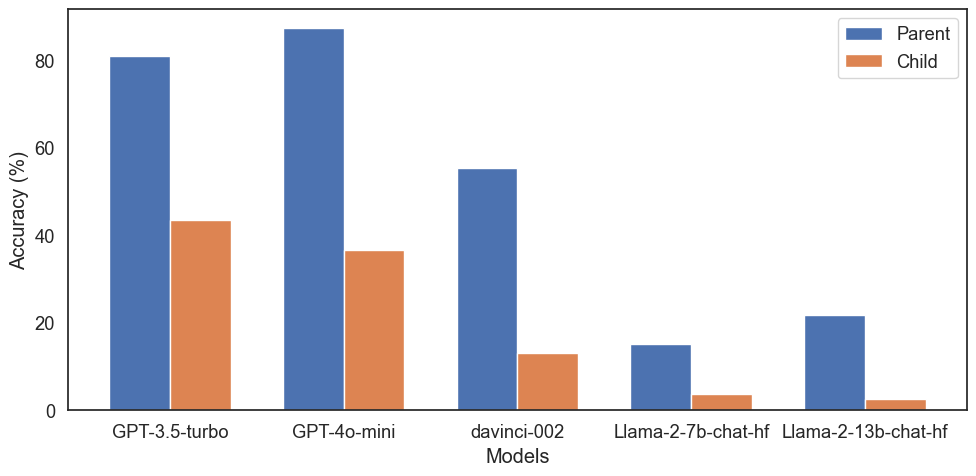

In [3]:

def bar_plot_completions(df: pd.DataFrame, model_names: list[str], title: str = None, name: str = None):
    """
    Args:
        df: dataframe containing completion results
        model_names: names of models to plot
        title: title of plot
    """
    # sns.set(font_scale=1.2)
    sns.set_theme(style="white", font_scale=1.2)

    
    # get percentage of relations that can be found for each model
    percentages = []
    for model_name in model_names:
        parent_field = f"{model_name}_parent_prob"
        child_field = f"{model_name}_child_prob"
            
        parent_percentage = df[parent_field].mean() * 100
        child_percentage = df[child_field].mean() * 100
        percentages.append((parent_percentage, child_percentage))

    # create a bar plot
    barWidth = 0.35
    r1 = range(len(model_names))
    r2 = [x + barWidth for x in r1]

    # plot data
    plt.figure(figsize=(10, 5))
    plt.bar(r1, [i[0] for i in percentages], width=barWidth, label='Parent')
    plt.bar(r2, [i[1] for i in percentages], width=barWidth, label='Child')

    # Add xticks in the middle of the group bars
    plt.xlabel('Models')
    
    # Calculate midpoints for tick positions
    midpoints = [(a + b) / 2 for a, b in zip(r1, r2)]
    
    plt.xticks(midpoints, [model_name_to_official(m) for m in model_names])

    plt.ylabel("Accuracy (%)")
    if title:
        plt.title(title)

    # Create legend & Show graphic
    plt.legend()
    plt.tight_layout()
    # save plot
    if name:
        plt.savefig(os.path.join(os.getcwd(), "data/celebrity_relations", "figures", f"{name}.pdf"), format="pdf")
    plt.show()

bar_plot_completions(combined_df, ["gpt-3.5-turbo", "gpt-4o-mini", "davinci-002", "Llama-2-7b-chat-hf", "Llama-2-13b-chat-hf"], name="Experiment_2_figure_1")


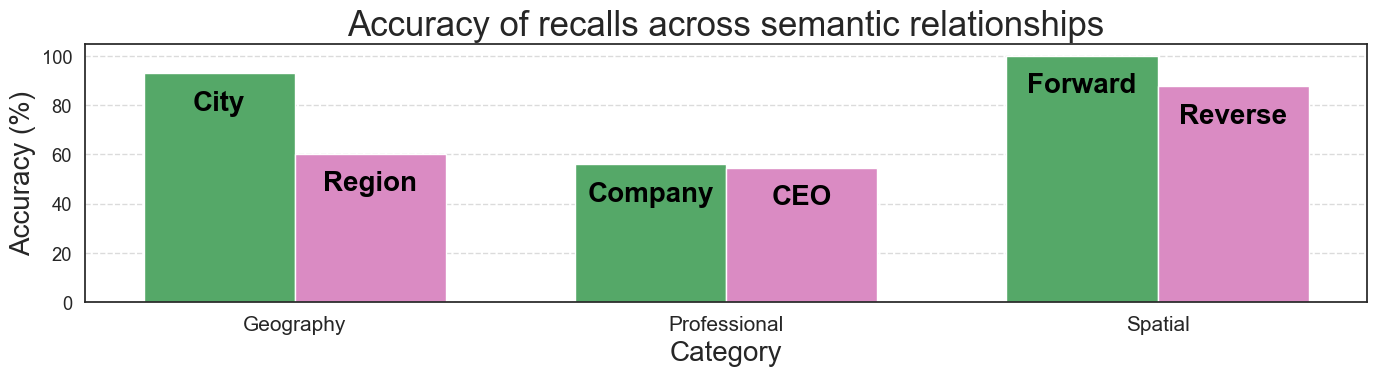

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Geography', 'Professional', 'Spatial']
subcategories = [['City', 'Region'], ['Company', 'CEO'], ['Forward', 'Reverse']]
values = [[92.88, 60.31], [55.97, 54.51], [100.0, 87.60]]

# Prepare for grouped bar chart
x = np.arange(len(categories))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(14, 4))

# Plotting bars and adding custom labels inside
for i, (label_pair, value_pair) in enumerate(zip(subcategories, values)):
    # First bar
    bar1 = ax.bar(x[i] - bar_width/2, value_pair[0], bar_width, label=label_pair[0] if i == 0 else "", color='C2')
    ax.annotate(f'{label_pair[0]}',
                xy=(x[i] - bar_width/2, value_pair[0]),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='top',
                color='black', fontsize=20, fontweight='bold')

    # Second bar
    bar2 = ax.bar(x[i] + bar_width/2, value_pair[1], bar_width, label=label_pair[1] if i == 0 else "", color='C6')
    ax.annotate(f'{label_pair[1]}',
                xy=(x[i] + bar_width/2, value_pair[1]),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='top',
                color='black', fontsize=20, fontweight='bold')

# Labels and formatting
ax.set_xlabel('Category', fontsize=20)
ax.set_ylabel('Accuracy (%)', fontsize=20)
ax.set_title('Accuracy of recalls across semantic relationships', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=15)

plt.ylim(0, 105)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(os.path.join(os.getcwd(), "data/celebrity_relations", "figures", f"Ablation_2.pdf"), format="pdf")

plt.show()


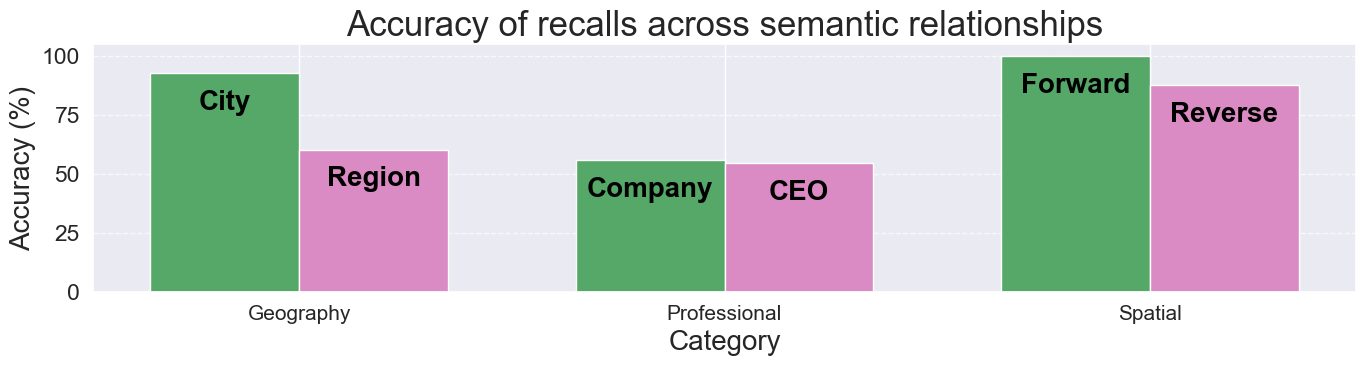

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Geography', 'Professional', 'Spatial']
subcategories = [['City', 'Region'], ['Company', 'CEO'], ['Forward', 'Reverse']]
values = [[92.88, 60.31], [55.97, 54.51], [100.0, 87.60]]

# Prepare for grouped bar chart
x = np.arange(len(categories))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(14, 4))

# Plotting bars and adding custom labels inside
for i, (label_pair, value_pair) in enumerate(zip(subcategories, values)):
    # First bar
    bar1 = ax.bar(x[i] - bar_width/2, value_pair[0], bar_width, label=label_pair[0] if i == 0 else "", color='C2')
    ax.annotate(f'{label_pair[0]}',
                xy=(x[i] - bar_width/2, value_pair[0]),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='top',
                color='black', fontsize=20, fontweight='bold')

    # Second bar
    bar2 = ax.bar(x[i] + bar_width/2, value_pair[1], bar_width, label=label_pair[1] if i == 0 else "", color='C6')
    ax.annotate(f'{label_pair[1]}',
                xy=(x[i] + bar_width/2, value_pair[1]),
                xytext=(0, -12),
                textcoords="offset points",
                ha='center', va='top',
                color='black', fontsize=20, fontweight='bold')

# Labels and formatting
ax.set_xlabel('Category', fontsize=20)
ax.set_ylabel('Accuracy (%)', fontsize=20)
ax.set_title('Accuracy of recalls across semantic relationships', fontsize=25)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=15)

plt.ylim(0, 105)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(os.path.join(os.getcwd(), "data/celebrity_relations", "figures", f"Ablation_2.pdf"), format="pdf")

plt.show()


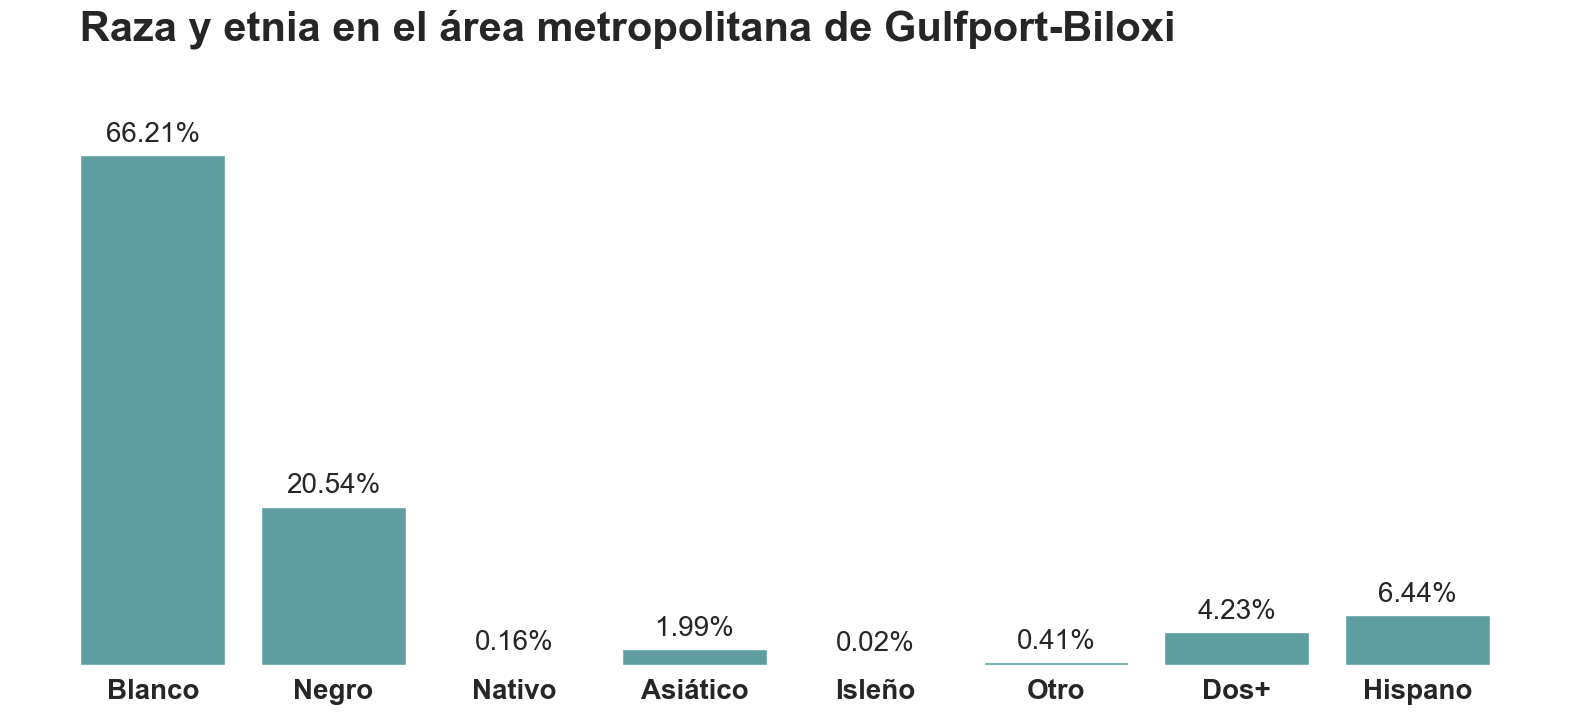

In [46]:
import matplotlib.pyplot as plt

# Data for the bar chart
categories = ['Blanco', 'Negro', 'Nativo', 'Asiático', 'Isleño', 'Otro', 'Dos+', 'Hispano']
percentages = [x / 418452 * 100 for x in [277069, 85943, 663, 8321, 104, 1696, 17693, 26963]]
annotations = [f"{percentage:.2f}%" for percentage in percentages]

# Create the bar chart
plt.figure(figsize=(20, 8))
bars = plt.bar(categories, percentages, color="cadetblue")

# Add annotations
for bar, annotation in zip(bars, annotations):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, annotation,
             ha='center', va='bottom', fontsize=20)

# Add title and adjust layout
plt.title('      Raza y etnia en el área metropolitana de Gulfport-Biloxi', fontsize=30, weight='bold', loc='left')
plt.xticks(fontsize=20, weight='bold')
plt.ylim(0, 80)
plt.yticks([])
plt.box(False)
plt.savefig("/Users/rickychen/Documents/SPA304/Images/Demographics.png")
plt.show()
